In [18]:
import sys

sys.path.append("..")

In [19]:
import os
import cv2 as cv

In [20]:
folder_normal_image_name = "../data/clear_and_cropped_image_data/normal/"
folder_malignant_image_name = "../data/clear_and_cropped_image_data/malignant/"

normal_image_names = os.listdir(folder_normal_image_name)
malignant_image_names = os.listdir(folder_malignant_image_name)

normal_image_paths = [folder_normal_image_name + path for path in os.listdir(folder_normal_image_name)]
malignant_image_paths = [folder_malignant_image_name + path for path in os.listdir(folder_malignant_image_name)]

In [21]:
import numpy as np
import pandas as pd

In [22]:
from src.feature_extraction.extract_figure_features import extract_figure_features

figure_features = extract_figure_features()

In [23]:
figure_features

{'294_3': {'figure_mean': 57.538140643623365,
  'figure_area': 3356.0,
  'figure_max': 124.0,
  'figure_min': 21.0,
  'figure_std': 17.518661240403727,
  'figure_perimeter': 239.78015279769897},
 '353_2': {'figure_mean': 86.3290856853135,
  'figure_area': 29585.0,
  'figure_max': 248.0,
  'figure_min': 14.0,
  'figure_std': 37.80723995474098,
  'figure_perimeter': 672.2737653255463},
 '92_3': {'figure_mean': 87.9527221963704,
  'figure_area': 10745.0,
  'figure_max': 228.0,
  'figure_min': 22.0,
  'figure_std': 27.598777265480955,
  'figure_perimeter': 382.30218625068665},
 '366_1': {'figure_mean': 99.63667718738814,
  'figure_area': 30733.0,
  'figure_max': 194.0,
  'figure_min': 16.0,
  'figure_std': 28.07844987172982,
  'figure_perimeter': 721.6384873390198},
 '130_1': {'figure_mean': 117.59804633357534,
  'figure_area': 30302.0,
  'figure_max': 252.0,
  'figure_min': 34.0,
  'figure_std': 27.162142797124137,
  'figure_perimeter': 691.1734845638275},
 '19_1': {'figure_mean': 62.0126

In [24]:
def extract_image_feature(image, label):
    return {
        f"{label}_mean": image.mean(),
        f"{label}_std": image.std(),
        f"{label}_min": image.min(),
        f"{label}_max": image.max(),
    }

In [25]:
all_image_paths = normal_image_paths + malignant_image_paths
all_image_name = normal_image_names + malignant_image_names

features = []

for i, image_path in enumerate(all_image_paths):
    image_number = all_image_name[i][all_image_name[i].find("_") + 1 : all_image_name[i].rfind(".")]
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

    blurred_image = cv.GaussianBlur(image, (5, 5), 1.4)

    curr_image_features = {"name": image_number}
    curr_image_features.update(extract_image_feature(image, "default"))

    curr_image_features.update(extract_image_feature(blurred_image, "blur"))

    sobel_x = cv.Sobel(blurred_image, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(blurred_image, cv.CV_64F, 0, 1, ksize=3)
    abs_sobel_x = cv.convertScaleAbs(sobel_x)
    abs_sobel_y = cv.convertScaleAbs(sobel_y)
    sobel_grad = cv.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    curr_image_features["sobel_mean"] = sobel_grad.mean()
    curr_image_features["sobel_std"] = sobel_grad.std()

    laplacian = cv.Laplacian(blurred_image, cv.CV_64F).astype(np.uint8)
    curr_image_features["laplacian_mean"] = laplacian.mean()
    curr_image_features["laplacian_std"] = laplacian.std()

    sigma = 0.9
    v = np.median(blurred_image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    canny = cv.Canny(blurred_image, lower, upper, L2gradient=True)
    curr_image_features["canny_mean"] = canny.mean()
    curr_image_features["canny_std"] = canny.std()

    curr_image_features.update(figure_features[image_number])

    if image_path in normal_image_paths:
        curr_image_features["target"] = 0
    else:
        curr_image_features["target"] = 1

    features.append(curr_image_features)

In [26]:
features

[{'name': '69_2',
  'default_mean': 88.00121701502917,
  'default_std': 38.134742749279475,
  'default_min': 13,
  'default_max': 255,
  'blur_mean': 87.99377970096202,
  'blur_std': 35.513408983299655,
  'blur_min': 19,
  'blur_max': 253,
  'sobel_mean': 27.873758837847237,
  'sobel_std': 21.44409715753082,
  'laplacian_mean': 111.45739481512962,
  'laplacian_std': 123.03130054741791,
  'canny_mean': 10.581076382181354,
  'canny_std': 50.85484539402995,
  'figure_mean': 72.02710975076519,
  'figure_area': 2287.0,
  'figure_max': 183.0,
  'figure_min': 18.0,
  'figure_std': 23.66899639013176,
  'figure_perimeter': 180.07686531543732,
  'target': 0},
 {'name': '380_1',
  'default_mean': 82.33570275877968,
  'default_std': 41.00958215112802,
  'default_min': 7,
  'default_max': 255,
  'blur_mean': 82.33477099823254,
  'blur_std': 37.85767942256911,
  'blur_min': 15,
  'blur_max': 231,
  'sobel_mean': 26.857104434027512,
  'sobel_std': 20.858098873363556,
  'laplacian_mean': 110.924930838

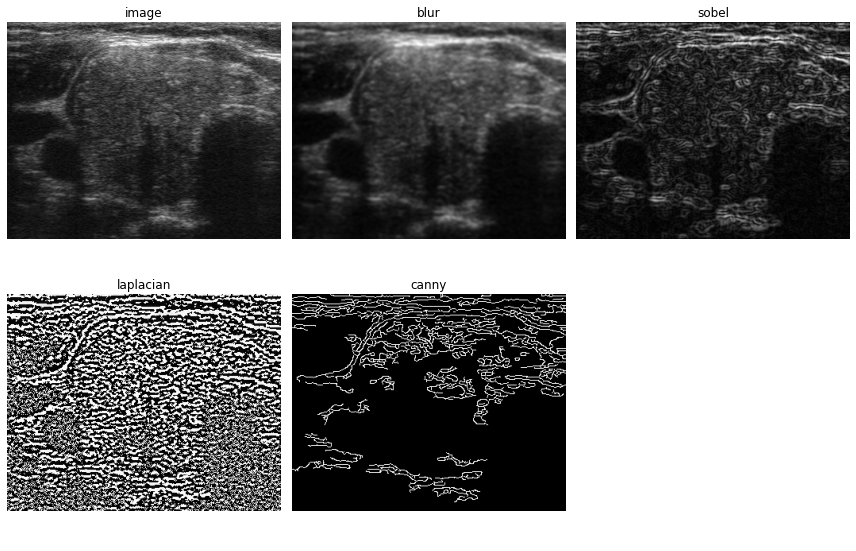

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

image = cv.imread(normal_image_paths[20], cv.IMREAD_GRAYSCALE)

blurred = cv.GaussianBlur(image, (5, 5), 1.4)

sobel_x = cv.Sobel(blurred, cv.CV_64F, 1, 0, ksize=3)
sobel_y = cv.Sobel(blurred, cv.CV_64F, 0, 1, ksize=3)
abs_sobel_x = cv.convertScaleAbs(sobel_x)
abs_sobel_y = cv.convertScaleAbs(sobel_y)
grad = cv.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

laplacian = cv.Laplacian(blurred, cv.CV_64F).astype(np.uint8)

sigma = 0.9
v = np.median(blurred)
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
canny = cv.Canny(blurred, lower, upper, L2gradient=True)

images = [image, blurred, grad, laplacian, canny]
titles = ["image", "blur", "sobel", "laplacian", "canny"]
for ax, img, title in zip(axes.flatten(), images, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [28]:
df = pd.DataFrame(features)
df.head()

,name,default_mean,default_std,default_min,default_max,blur_mean,blur_std,blur_min,blur_max,sobel_mean,...,laplacian_std,canny_mean,canny_std,figure_mean,figure_area,figure_max,figure_min,figure_std,figure_perimeter,target
0,69_2,88.001217,38.134743,13,255,87.993780,35.513409,19,253,27.873759,...,123.031301,10.581076,50.854845,72.027110,2287.0,183.0,18.0,23.668996,180.076865,0
1,380_1,82.335703,41.009582,7,255,82.334771,37.857679,15,231,26.857104,...,122.794972,17.555377,64.563379,71.692199,57235.0,249.0,9.0,32.342588,913.065723,0
2,158_2,97.597160,43.821470,7,255,97.597751,40.915805,25,248,28.786973,...,122.727027,14.607444,59.258086,75.991837,6248.0,216.0,29.0,24.794651,299.780540,0
3,66_1,78.756686,31.397057,9,245,78.757682,27.661744,25,202,25.348055,...,123.245893,17.505292,64.478014,63.814262,12523.0,173.0,11.0,22.628529,557.980631,0
4,69_3,93.166859,37.735053,12,255,93.159992,34.687413,22,247,28.895076,...,123.075315,9.070826,47.231141,82.739580,2903.0,189.0,19.0,23.651310,210.073542,0


In [29]:
df.shape

(301, 22)

In [30]:
df["target"].value_counts()

target
1    193
0    108
Name: count, dtype: int64

In [31]:
len(normal_image_names), len(malignant_image_names)

(108, 193)

In [32]:
df.isna().sum()

name                0
default_mean        0
default_std         0
default_min         0
default_max         0
blur_mean           0
blur_std            0
blur_min            0
blur_max            0
sobel_mean          0
sobel_std           0
laplacian_mean      0
laplacian_std       0
canny_mean          0
canny_std           0
figure_mean         0
figure_area         0
figure_max          0
figure_min          0
figure_std          0
figure_perimeter    0
target              0
dtype: int64